In [1]:
import numpy as np
import h5py
import sys
sys.path.append('/Users/eframe/cci2/src')
import calibrate as calib
import eventAnalysis as ea
import tables
import matplotlib.pyplot as plt
import codedAperture as ca
import glob
from scipy import ndimage
import more_itertools as mit
import pandas as pd

ModuleNotFoundError: No module named 'calibrate'

In [3]:
file = '/Users/eframe/cci2/data/slitdiagonal2.h5'
outfile = '/Users/eframe/cci2/data/slitdiagonal2_interp.h5'
outfile2 = '/Users/eframe/cci2/data/slitdiagonal2_interp2.h5'

In [4]:
# Loading R-value maps
tabx1 = pd.read_hdf('/Users/eframe/cci2/data/rval/rvalMap_x1.h5', 'vals')
tabx2 = pd.read_hdf('/Users/eframe/cci2/data/rval/rvalMap_x2.h5', 'vals')
taby1 = pd.read_hdf('/Users/eframe/cci2/data/rval/rvalMap_y1.h5', 'vals')
taby2 = pd.read_hdf('/Users/eframe/cci2/data/rval/rvalMap_y2.h5', 'vals')

In [5]:
# Linking Raw Data to Event Data
f = tables.open_file(file, 'r')
edata = f.root.EventData.read().view(np.recarray)
rdata = f.root.RawData.read().view(np.recarray)
edata.rid = np.arange(len(edata))
edata = np.sort(edata, order='timestamp')
idx1, idx2 = ea.lump_edata(edata, twindow=25)

In [6]:
# Grouping Singles Events
singles = []
for i in np.arange( len(idx1) ):
    event = edata[idx1[i]:idx2[i]]    
    if ea.is_single(event) is True: singles.append(event)  
    else: continue

In [13]:
pos = []
for i in np.arange( len(singles) ): 
    x, y = False, False
    x2, y2 = False, False
    ## Sorting event data by strip number ##   
    event = singles[i]
    
    iterable = np.sort(event, order='detector')
    strips = [list(group) for group in mit.consecutive_groups(iterable.detector)]
    
    ## Getting indices of sorted strips ##
    yindex = strips[0] - strips[0][0] 
    xindex = strips[1] - strips[1][0] + yindex[-1] + 1 

    masktrigy = iterable[yindex].trigger == 1
    masktrigx = iterable[xindex].trigger == 1
    
    ## Getting interpolated z-coordinate ##
    ## If charge sharing, dt50 comes from AC and DC strips with maximum energy ##
    esort = np.sort(event, order='ADC_value')
    detsort = np.sort(esort[-2:], order='detector')
    E = max(esort.ADC_value)
    dt50 = detsort.t50[-1] - detsort.t50[0] 
    dt = int(detsort.timestamp[-1]) - int(detsort.timestamp[0])
    dt50_new = dt + dt50
    z = dt50_new * 0.3215503 + 7.9596899
    if z < 0: z == 0 
    elif z > 15: z == 15
    
    ## Getting interpolated y-coordinate ##
    if ( len(iterable[yindex][masktrigy]) == 2 ) and ( min(iterable[yindex][masktrigy].ADC_value) != 0 ):
        # For charge sharing
        y = ( np.sort(iterable[yindex][masktrigy], order='detector').detector[0] - 38*0 ) * 2 - 1 + 0.5
    else:
        ystrip = np.sort(iterable[yindex], order='ADC_value').detector
        yold = ( ystrip[-1] - 38*0 ) * 2 - 1 
        iy = np.where(np.sort(iterable[yindex], order='detector').detector == ystrip[-1] )[0][0]
        yrids = iterable[yindex].rid
        ay1 = np.max(rdata[yrids[0]][30:50]) - np.mean(rdata[yrids[0]][:10])
        ay2 = np.max(rdata[yrids[-1]][30:50]) - np.mean(rdata[yrids[-1]][:10])
        Ry = np.divide( ( ay2 - ay1 ), ( ay2 + ay1 ), out=np.zeros_like(ay2 - ay1), where=(ay2 + ay1)!=0 )
        if ( len(ystrip) == 3 ) and ( iy == 1 ):
            y = yold + 0.5 * np.sign(Ry)
        elif ( len(ystrip) == 2 ) and ( iy == 1 ):
            j1 = ea.find_nearest(taby1['z'], z)
            j2 = ea.find_nearest(taby1[j1:j1+19]['ratio'], np.divide( ay1, E, out=np.zeros_like(ay1), where=E!=0 ))
            R = taby1[j1:j1+19]['rval'].values[j2]
            y = yold + 0.5 * np.sign(R)
        elif ( len(ystrip) == 2 ) and ( iy == 0 ):
            j1 = ea.find_nearest(taby2['z'], z)
            j2 = ea.find_nearest(taby2[j1:j1+19]['ratio'], np.divide( ay2, E, out=np.zeros_like(ay2), where=E!=0 ))
            R = taby2[j1:j1+19]['rval'].values[j2]
            y = yold + 0.5 * np.sign(R)
               
    ## Getting interpolated x-coordinate ##
    if ( len(iterable[xindex][masktrigx]) == 2 ) and ( min(iterable[xindex][masktrigx].ADC_value) != 0 ):
        # For charge sharing
        x = ( np.sort(iterable[xindex][masktrigx], order='detector').detector[0] - 38*2 ) * 2 - 1 + 0.5
    else:
        xstrip = np.sort(iterable[xindex], order='ADC_value').detector
        xold = ( xstrip[-1] - 38*2 ) * 2 - 1 
        ix = np.where(np.sort(iterable[xindex], order='detector').detector == xstrip[-1] )[0][0]
        xrids = iterable[xindex].rid
        ax1 = np.max(rdata[xrids[0]][30:50]) - np.mean(rdata[xrids[0]][:10])
        ax2 = np.max(rdata[xrids[-1]][30:50]) - np.mean(rdata[xrids[-1]][:10])
        Rx = np.divide( ( ax2 - ax1 ), ( ax2 + ax1 ), out=np.zeros_like(ax2 - ax1), where=(ax2 + ax1)!=0 )
        if ( len(xstrip) == 3 ) and ( ix == 1 ): 
            x = xold + 0.5 * np.sign(Rx)
        elif ( len(xstrip) == 2 ) and ( ix == 1 ):
            j1 = ea.find_nearest(tabx1['z'], z)
            j2 = ea.find_nearest(tabx1[j1:j1+19]['ratio'], np.divide( ax1, E, out=np.zeros_like(ax1), where=E!=0 ))
            R = tabx1[j1:j1+19]['rval'].values[j2]
            x = xold + 0.5 * np.sign(R)
        elif ( len(xstrip) == 2 ) and ( ix == 0 ):
            j1 = ea.find_nearest(tabx2['z'], z)
            j2 = ea.find_nearest(tabx2[j1:j1+19]['ratio'], np.divide( ax2, E, out=np.zeros_like(ax2), where=E!=0 ))
            R = tabx2[j1:j1+19]['rval'].values[j2]
            x = xold + 0.5 * np.sign(R)
            
    if (x is not False) and (y is not False):
        pos.append([E, x, y, z, dt, dt50])

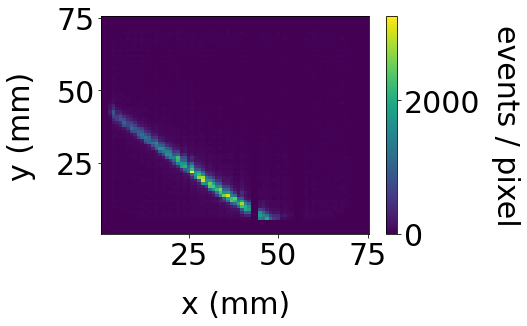

In [14]:
# Binning Singles Events by Interaction Position
%matplotlib inline
l11 = f.root.Interactions.Single.read()
pos = np.array(pos)
xedges, yedges = np.arange(0.5, 76.5, 1),  np.arange(0.5, 76.5, 1)
grid, X, Y = np.histogram2d(pos[:,1], pos[:,2], bins=(xedges, yedges) )
grid = np.flip(grid, 1)
fig, ax = plt.subplots()
im = ax.pcolormesh(X, Y, grid.T)
ax.tick_params(labelsize=30)
ax.set_xlabel('x (mm)', fontsize=30, labelpad=20)
ax.set_ylabel('y (mm)', fontsize=30, labelpad=20)
cbar = plt.colorbar(im)
cbar.set_label(label='events / pixel', rotation=270, fontsize=30, labelpad=40)
cbar.ax.tick_params(labelsize=30)
plt.show()

In [16]:
pos = np.array(pos)
df = pd.DataFrame( {'energy': pos[:,0], 'x': pos[:,1], 'y': pos[:,2], 'z': pos[:,3]} )
df.to_hdf( outfile, key='vals', mode='w' )

In [ ]:
# # For building R-value tables
# ratiox1, ratiox2, ratioy1, ratioy2, rvalx1, rvalx2, zvalx1, zvalx2, rvaly1, rvaly2, zvaly1, zvaly2 = [], [], [], [], [], [], [], [], [], [], [], []
# if (  np.divide( ax1, E, out=np.zeros_like(ax1), where=E!=0 ) >= 0 ) and (  np.divide( ax1, E, out=np.zeros_like(ax1), where=E!=0 ) <= 1 ):
#     ratiox1.append( np.divide( ax1, E, out=np.zeros_like(ax1), where=E!=0 ))
#     zvalx1.append(z)
#     rvalx1.append(Rx)
# if ( np.divide( ax2, E, out=np.zeros_like(ax2), where=E!=0 ) >= 0 ) and ( np.divide( ax2, E, out=np.zeros_like(ax2), where=E!=0 ) <= 1 ):
#     ratiox2.append(ax2/E)
#     zvalx2.append(z)
#     rvalx2.append(Rx)  
# if ( np.divide( ay1, E, out=np.zeros_like(ay1), where=E!=0 ) >= 0 ) and ( np.divide( ay1, E, out=np.zeros_like(ay1), where=E!=0 ) <= 1 ):
#     ratioy1.append(np.divide( ay1, E, out=np.zeros_like(ay1), where=E!=0 ))
#     zvaly1.append(z)
#     rvaly1.append(Ry)
# if ( np.divide( ay2, E, out=np.zeros_like(ay2), where=E!=0 ) >= 0 ) and ( np.divide( ay2, E, out=np.zeros_like(ay2), where=E!=0 ) <= 1 ):
#     ratioy2.append(np.divide( ay2, E, out=np.zeros_like(ay2), where=E!=0 ))
#     zvaly2.append(z)
#     rvaly2.append(Ry)

In [ ]:
# ## Histogramming R-value by depth of interaction and single boarding strip
# ratio, zval, rval = ratioy2, zvaly2, rvaly2
# redges, zedges = np.arange(0, 1, 0.05), np.arange(0, 16, 1)
# hist1, redges, zedges = np.histogram2d(ratio, zval, bins=(redges, zedges), weights = rval)
# hist2, x, y = np.histogram2d(ratio, zval, bins=(redges, zedges)) 
# grid = np.divide( hist1, hist2, out=np.zeros_like(hist1), where=hist2!=0 )
# fig, ax = plt.subplots()
# im = ax.pcolormesh(redges, zedges, grid.T)
# cbar = plt.colorbar(im)
# cbar.set_label(label='Rval', rotation=270, fontsize=20, labelpad=20)
# cbar.ax.tick_params(labelsize=20)
# plt.show()

In [ ]:
# ## Saving R-value Tables
# xedges, yedges = np.arange(0.025, 0.975, 0.05), np.arange(0.5, 15.5, 1)
# X, Y = np.meshgrid(xedges, yedges)
# df = pd.DataFrame( {'z': Y.flatten(), 'ratio':X.flatten(), 'rval':im.get_array() } )
# df.to_hdf( '/Users/eframe/cci2/data/rvalMap_y2.h5', key='vals', mode='w' )

In [ ]:
# fig, ax = plt.subplots()
# ax.tick_params(labelsize=30)
# ax.set_xlabel('Time (10 ns)', fontsize=30, labelpad=20)
# ax.set_ylabel('Induced Charge Signal', fontsize=30, labelpad=20)
# plt.plot(rdata[xrids[0]][:100]- np.mean(rdata[xrids[0]][:10]), linewidth = 3, label=r'Neighbor $X-1$')
# plt.plot(rdata[xrids[1]][:100]- np.mean(rdata[xrids[1]][:10]), linewidth = 3, label=r'Trigger $X$') 
# plt.plot(rdata[xrids[-1]][:100]- np.mean(rdata[xrids[-1]][:10]), linewidth = 3, label=r'Neighbor $X+1$')
# plt.legend(fontsize=30)
# plt.show()